
### PyTorch 딥러닝 챗봇
https://wikidocs.net/157552

In [11]:
# import library
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.core.module import LightningModule
from torchmetrics.classification import Accuracy
import matplotlib.pyplot as plt

In [7]:
# dataset and loader
training_data = datasets.FashionMNIST(
  root='./data',
  train=True,
  download=True,
  transform=ToTensor()
)

test_data = datasets.FashionMNIST(
  root='./data',
  train=False,
  download=True,
  transform=ToTensor()
)

# 학습 데이터와 검증 데이터 분리
train_dataset, val_dataset = random_split(training_data, [55000, 5000])

lr = 1e-3
batch_size=64
epochs = 10

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [13]:
# Class
from pytorch_lightning.utilities.types import OptimizerLRScheduler
num_classes = 10

class LitModel(LightningModule):
  # 신경망 정의
  def __init__(self):
    super().__init__()
    self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)
    self.model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 512),
      torch.nn.BatchNorm1d(512),  # batch normaization for Internal Covariant Shift: 각  층별로 데이터 분포가 달라질 수 있음.
      nn.ReLU(),
      nn.Linear(512, 256),
      torch.nn.BatchNorm1d(256),
      nn.ReLU(),
      nn.Linear(256, 64),
      torch.nn.BatchNorm1d(64),
      nn.ReLU(),
      nn.Linear(64,10)  # 10 category
    )

  def forward(self, x):
    return self.model(x)
  
  # 학습
  def training_step(self, batch, batch_index):
    x, y = batch
    y_hat = self(x) # predict
    loss = F.cross_entropy(y_hat, y)
    return loss
  
  # model 성능 체크
  def validation_step(self, batch, batch_index):
    x, y = batch
    logits = self(x)
    acc = self.accuracy(logits, y)
    loss = F.cross_entropy(logits, y)
    metrics = {'val_acc': acc, 'val_loss': loss}
    self.log_dict(metrics)

  def test_step(self, batch, batch_index):
    x, y = batch
    logits = self(x)
    acc = self.accuracy(logits, y)
    loss = F.cross_entropy(logits, y)
    metrics = {'test_acc': acc, 'test_loss': loss}
    self.log_dict(metrics)

  def configure_optimizers(self) -> OptimizerLRScheduler:
    return torch.optim.AdamW(self.parameters(), lr=lr)

In [14]:
model = LitModel()
trainer = Trainer(max_epochs=epochs)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 552 K 
------------------------------------------------
552 K     Trainable params
0         Non-trainable params
552 K     Total params
2.208     Total estimated model params size (MB)


/home/whpark/miniconda3/envs/dev/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/whpark/miniconda3/envs/dev/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 860/860 [00:29<00:00, 28.74it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 860/860 [00:29<00:00, 28.71it/s, v_num=1]


In [16]:
trainer.test(model, test_dataloader)

/home/whpark/miniconda3/envs/dev/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 119.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8618999719619751
        test_loss           0.48708978295326233
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8618999719619751, 'test_loss': 0.48708978295326233}]

In [17]:
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}

In [ ]:
print(test_data)
len(test_dataloader)  # 10,000 / 64  --> 157번의 batch
test_data[0][0]

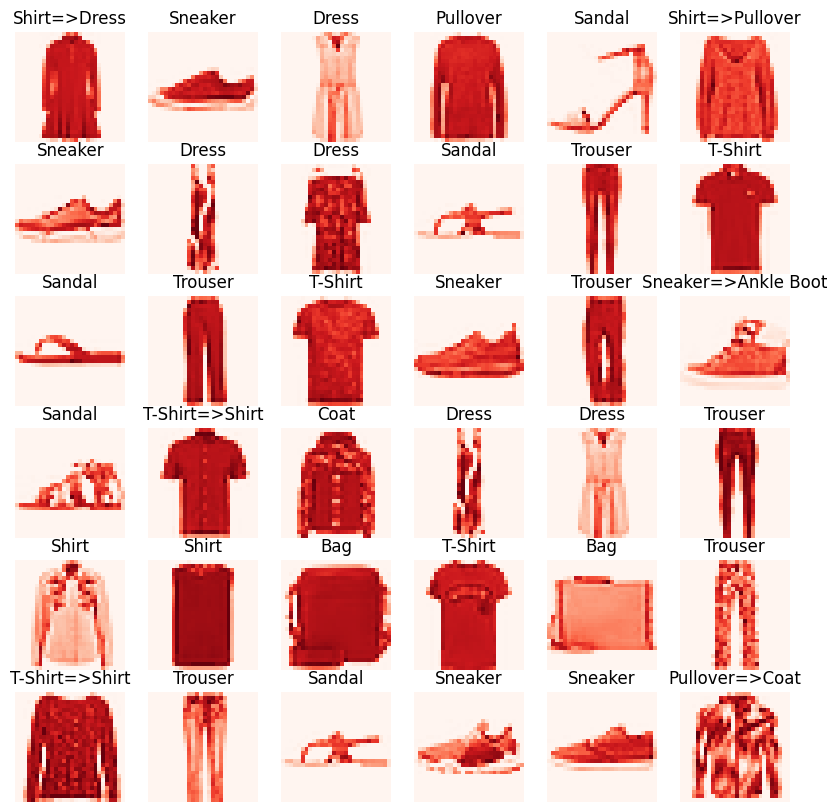

In [24]:
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))

model.eval()
for i in range(1, columns*rows+1):
  data_idx = torch.randint(len(test_dataloader), (1,)).item()    # batch number 0 ~ 157
  input_img = test_data[data_idx][0].unsqueeze(dim=0)

  output = model(input_img)
  # torch.max(input, dim, keepdim=False, *, out=None)
  # https://pytorch.org/docs/stable/generated/torch.max.html
  _, argmax = torch.max(output, 1)
  pred = label_tags[argmax.item()]
  label = label_tags[test_data[data_idx][1]]

  fig.add_subplot(rows, columns, i)
  if pred == label:
    plt.title(pred)
    cmap = "Reds"
  else:
    plt.title(pred + '=>' + label)
    cmap = 'Reds'
  plot_img = test_data[data_idx][0][0,:,:]
  plt.imshow(plot_img, cmap=cmap)
  plt.axis('off')

plt.show()
